In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn

%matplotlib inline

from utils import tokenizer
from wordcloud import WordCloud
import nltk
from nltk import FreqDist

# Load Data

In [2]:
lyrics = pd.read_csv("data/lyrics.csv")

lyrics.sample(10)

,song_name,album_name,band_name,lyrics
159115,Going Nowhere,grindfinale,nasum,"\nBorn and raised the clock is ticking, what w..."
165004,Elegiac,monuments,thisortheapocalypse,My place lies not in the immortal sea\nI am ju...
17787,Warfiend,wintercampaign,battalion,Chaosbringer - Cenotaph\nMythology - Wargod\n\...
111529,Worship Mindset,neosis,neosis,Defective decisions have been taken in the nam...
67923,The Lost Love Song,deeperintothenight,shamrain,Speak to me now\nShare a few words\nDistant ec...
44056,Dark Stairs Of R'lyeh,dreamquest,evol,\nDarkness surrounds me\nWhen I fall asleep\nS...
28312,My Will Be Done,themarch,unearth,So many have lost their way\nSo many have fall...
80644,Hail To The Grail,returntocastlegrailskull,grailknights,Impatiently\nThey can't wait to fight\nThe hor...
57497,Fall Of Man,fallofman,maleficusangelus,Once their wretchedness\nReigned our time and ...
115027,Running Out Of Time,sacredpathways,artension,Now that my life is changing\nSomething is mis...


In [21]:
# load some bands to focus on
with open("data/artists.txt", "r") as f:
    bands = f.read().strip().replace('"', "").split("\n")
    f.close()
    
# and some stopwords to remove
with open("data/stopwords.txt", "r") as f:
    STOP_WORDS = set(f.read().strip().split("\n"))

# Swear words vs Readbility 

In [4]:
import readability

with open("data/google_swear_words.txt", "r") as f:
    swear_words = f.read().strip().replace('"', "").split("\n")
    swear_words = [s.split(":")[0] for s in swear_words]
    f.close()
    
def count_swear_word_ratio(text):
    counter = 0
    for swear_word in swear_words:
        counter += text.count(swear_word)
        
    number_of_words = len(tokenizer.tokenize_words(text))
    return counter / number_of_words

def measure_readability(text):
    result = readability.getmeasures(text)
    return result['readability grades']["SMOGIndex"]

In [5]:
%%time
band_lyrics = (
    lyrics
    [lyrics.band_name.isin(bands)]
    .groupby("band_name")
    .lyrics
    .sum()
    .reset_index()
)

band_lyrics["swear_word_ratio"] = band_lyrics.lyrics.apply(count_swear_word_ratio)
band_lyrics["readability"] = band_lyrics.lyrics.apply(measure_readability)


CPU times: user 40.2 s, sys: 76 ms, total: 40.3 s
Wall time: 40.3 s


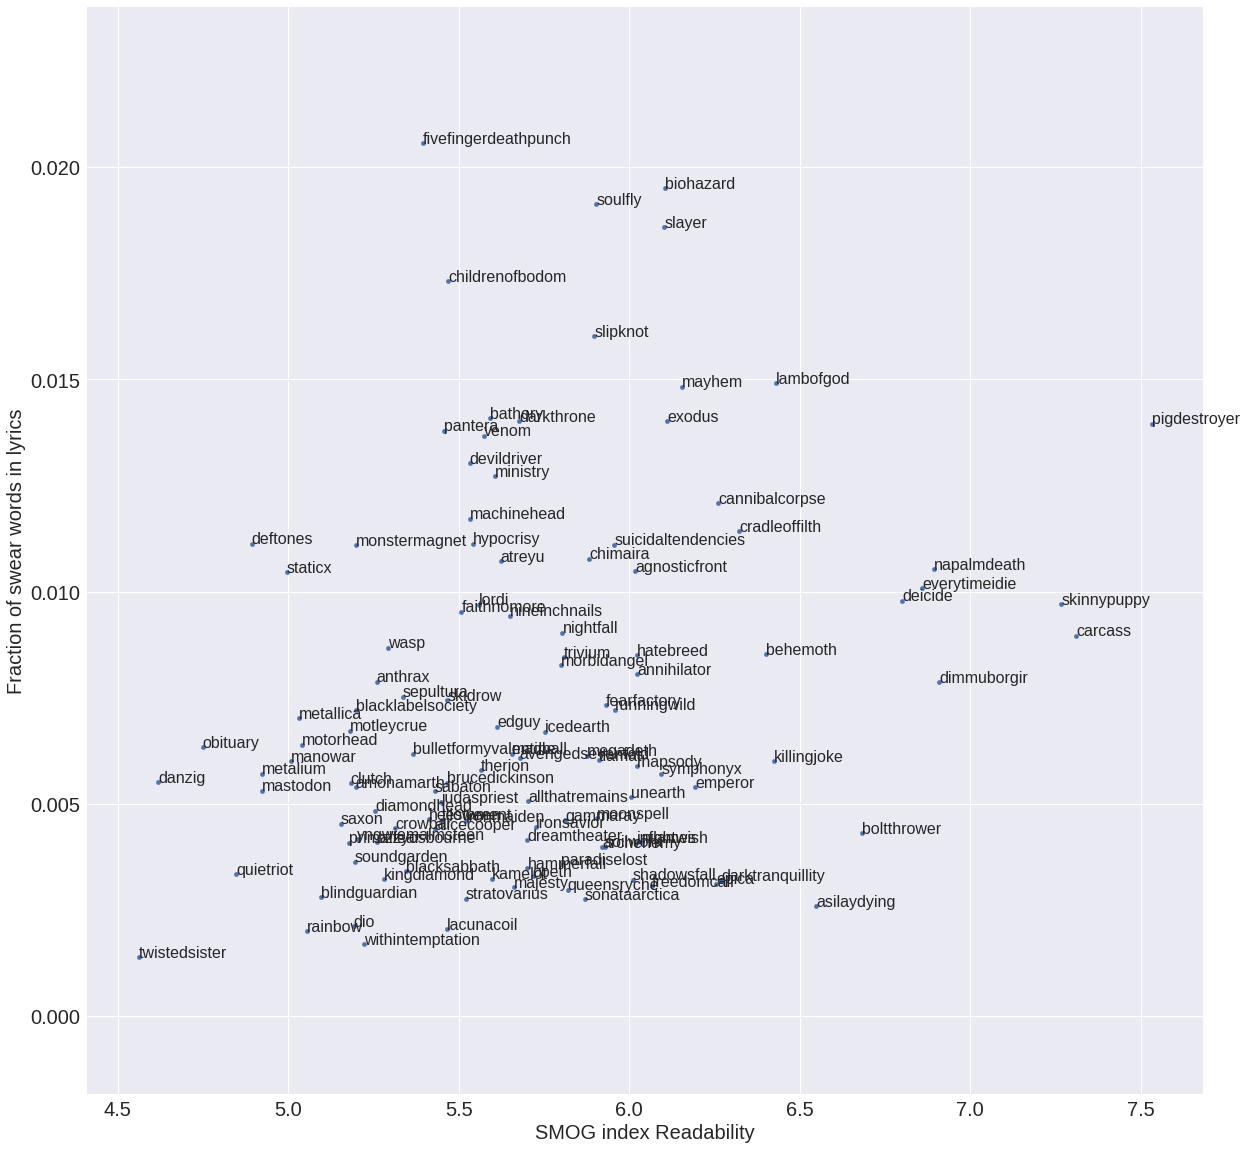

In [6]:
fig, ax = plt.subplots(figsize=(20,20))

band_lyrics.plot(kind="scatter", y="swear_word_ratio", x="readability", ax=ax)

for i, point in band_lyrics.iterrows():
        ax.text(point['readability'], point['swear_word_ratio'], str(point['band_name']), 
                fontsize=16)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("SMOG index Readability", fontsize=20)
plt.ylabel("Fraction of swear words in lyrics", fontsize=20)

plt.savefig("resources/reading-vs-swearing.png", bbox_inches='tight')

# Counting Words 

In [7]:
metal_freq_dist = FreqDist(tokenizer.tokenize_words(" ".join(lyrics.lyrics.values)))

In [8]:
metal_freq_dist.most_common(10)

[('\n', 5609181),
 ('the', 1627376),
 (',', 982339),
 ('.', 822335),
 ('to', 689487),
 ('of', 683658),
 ('i', 659855),
 ('you', 593293),
 ('and', 575009),
 ('a', 472162)]

In [9]:
# remove punctuation and stopwords
for stopword in STOP_WORDS:
    if stopword in metal_freq_dist:
        del metal_freq_dist[stopword]
        
for punctuation in tokenizer.CHARACTERS_TO_SPLIT:
    if punctuation in metal_freq_dist:
        del metal_freq_dist[punctuation]

In [7]:
def plot_word_cloud(words, filename=None):
    wordcloud = WordCloud(
        width=800,
        height=600,
        max_words=500,
        scale=3,
    )

    wordcloud.generate_from_frequencies(dict(words))
    plt.figure(figsize=(15,20))
    plt.imshow(wordcloud)
    plt.axis("off")
    
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')
    
    plt.show()

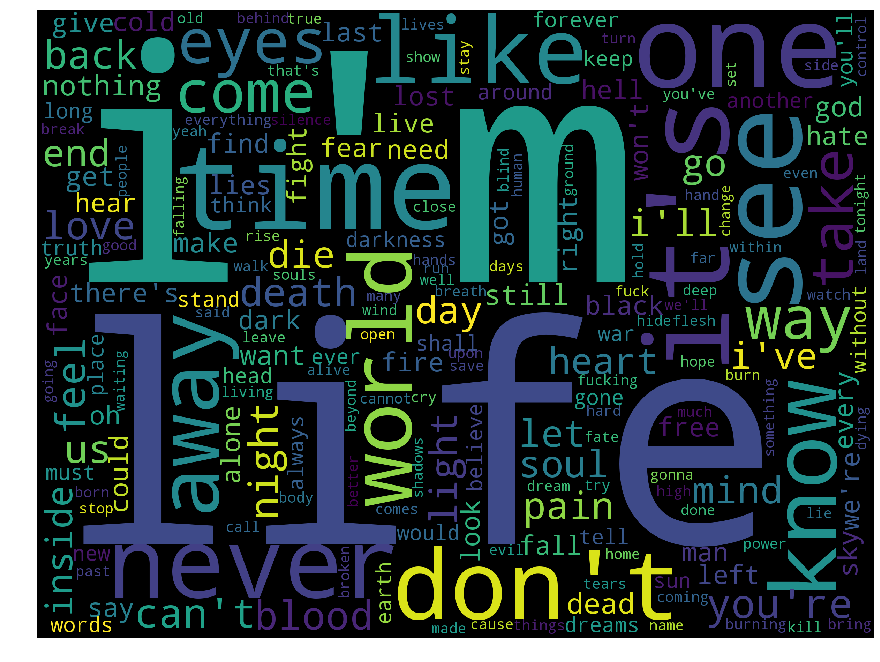

In [11]:
plot_word_cloud(metal_freq_dist.most_common(200), "resources/full-metal-wordcloud.png")

In [12]:
metal_word_frequencies = [x[1] for x in metal_freq_dist.most_common(200000)]

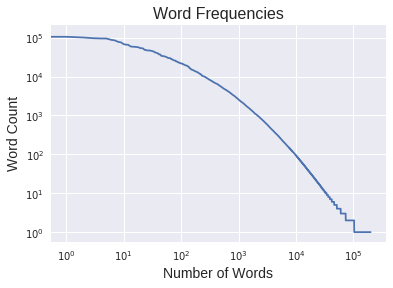

In [13]:
plt.plot(metal_word_frequencies)

plt.yscale("log")
plt.xscale("log")

plt.title("Word Frequencies", fontsize=16)
plt.ylabel("Word Count", fontsize=14)
plt.xlabel("Number of Words", fontsize=14)

plt.savefig("resources/metal-word-distribution.png")

# Most Metal Words 

In [14]:
from math import log

# load english words from 
english_freq_dist = FreqDist([w.lower() for w in nltk.corpus.brown.words()
                              if w not in STOP_WORDS])

# remove rare words and get total count
english_freq_dist = {k:v for k,v in english_freq_dist.items() if v > 5}
n_english = sum(english_freq_dist.values())

# remove rare words from metal distribution
metal_freq_dist = {k:v for k,v in metal_freq_dist.items() if v > 5}
n_metal = sum(metal_freq_dist.values())

# combine
metalness = {}

for w in metal_freq_dist.keys() & english_freq_dist.keys():
    if len(w) > 2:
        metalness[w] = log( (metal_freq_dist[w] / n_metal) / (english_freq_dist[w] / n_english))

In [15]:
def list_to_markdown_table(lst, headings):
    assert(len(headings) == len(lst[0]))
    results = ""
    results += "|".join(headings) + "\n"
    results += "|".join(["---"] * len(headings)) + "\n"
    for elem in lst:
        results += "|".join([str(s) for s in elem]) + "\n"
        
    return results

sorted_ranked_metal = [(x[0], x[1][0], "{:.2f}".format(x[1][1])) for x in
                       enumerate(sorted(metalness.items(), key=lambda x: -x[1]))]

headings = ["Rank", "Word", "Metalness"]
    
top_10 = list_to_markdown_table(sorted_ranked_metal[:10:1], headings)
botton_10 = list_to_markdown_table(sorted_ranked_metal[:-10:-1], headings)


In [16]:
print(top_10)

Rank|Word|Metalness
---|---|---
0|burn|4.11
1|cries|3.93
2|veins|3.89
3|eternity|3.87
4|breathe|3.84
5|beast|3.84
6|gonna|3.84
7|demons|3.84
8|ashes|3.81
9|soul|3.71



In [17]:
print(botton_10)

Rank|Word|Metalness
---|---|---
10174|particularly|-6.03
10173|indicated|-6.01
10172|secretary|-5.98
10171|university|-5.85
10170|committee|-5.85
10169|relatively|-5.77
10168|approximately|-5.59
10167|noted|-5.42
10166|chairman|-5.38



In [24]:
import json

with open("data/metalness.json", "w") as f:
    json.dump(metalness, f)

# Comparing Bands 

In [28]:
def get_all_lyrics_from_string(s):
    return [w for w in tokenizer.tokenize_words(s)
            if ((w not in STOP_WORDS) and 
                             (w not in tokenizer.CHARACTERS_TO_SPLIT))]


motorhead_fd = FreqDist(get_all_lyrics_from_string(" ".join(lyrics[lyrics.band_name == "motorhead"].lyrics.values)))
machinehead_fd = FreqDist(get_all_lyrics_from_string(" ".join(lyrics[lyrics.band_name == "machinehead"].lyrics.values)))
diamondhead_fd = FreqDist(get_all_lyrics_from_string(" ".join(lyrics[lyrics.band_name == "diamondhead"].lyrics.values)))

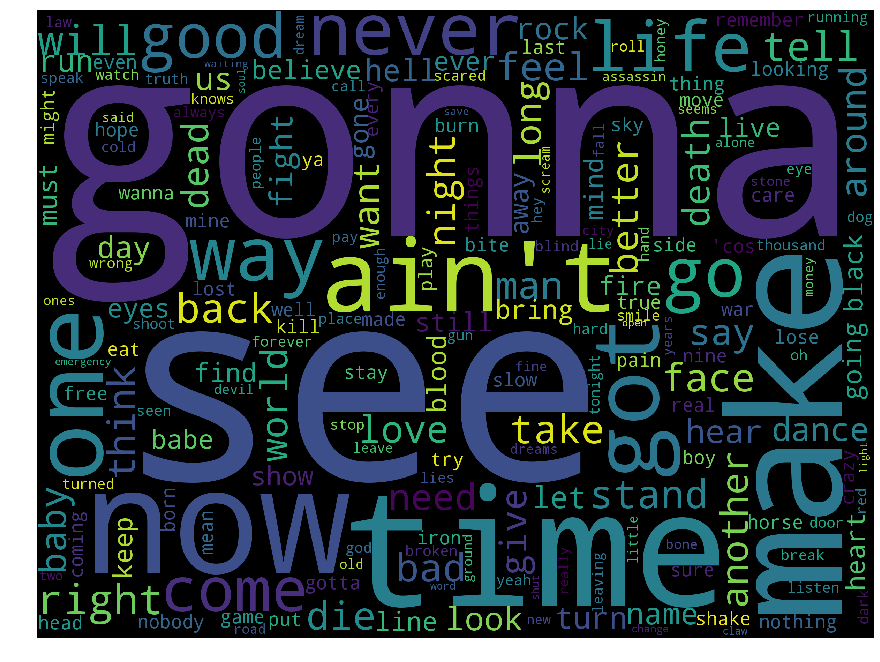

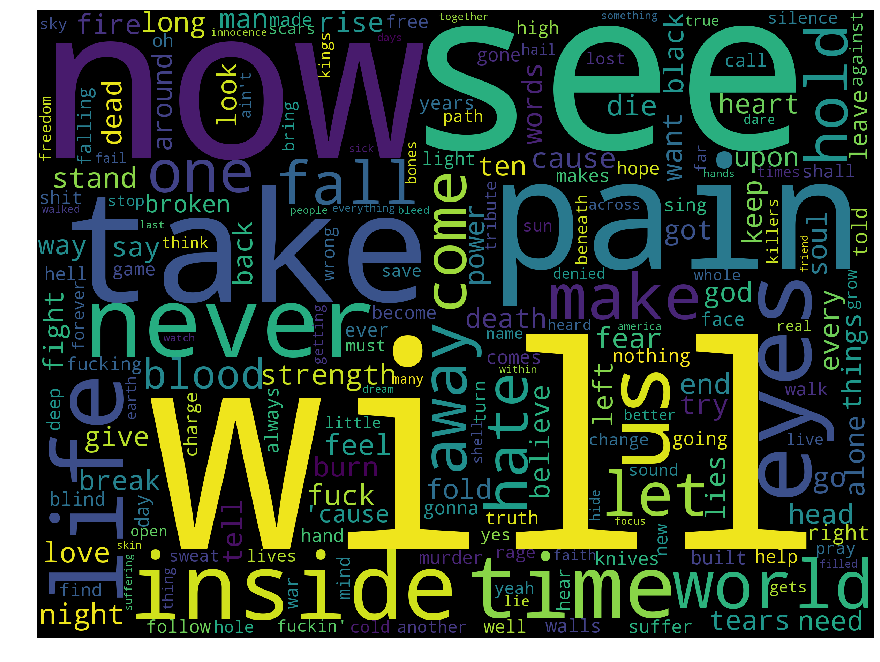

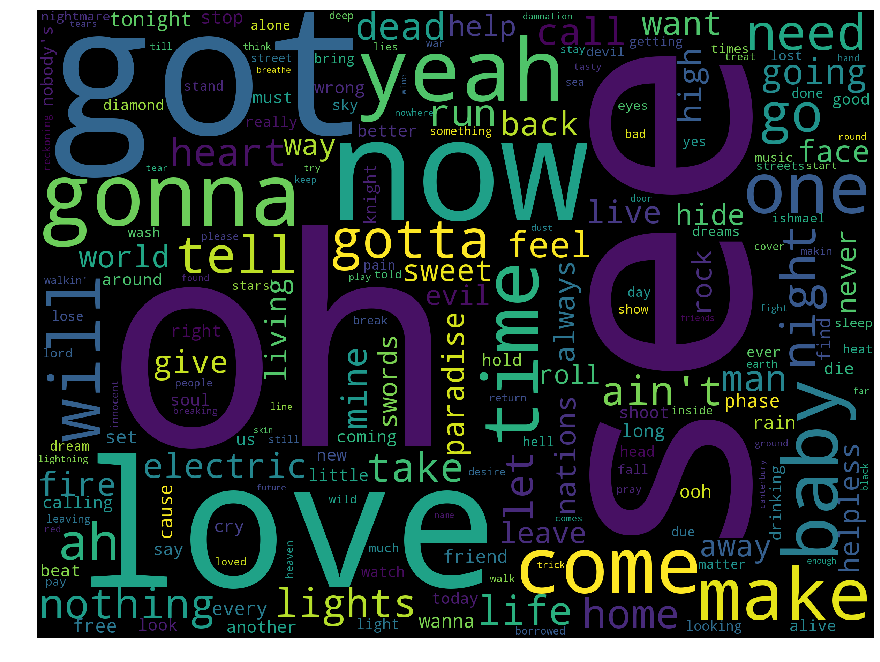

In [29]:
plot_word_cloud(motorhead_fd.most_common(200), "resources/motorhead-freq-wordcloud.png")
plot_word_cloud(machinehead_fd.most_common(200), "resources/machinehead-freq-wordcloud.png")
plot_word_cloud(diamondhead_fd.most_common(200), "resources/diamondhead-freq-wordcloud.png")

In [36]:
headbands = ["diamondhead", "machinehead", "motorhead"]

three_band_fd = FreqDist(get_all_lyrics_from_string(" ".join(lyrics[lyrics.band_name.isin(headbands)].lyrics.values)))

def get_ll(freq1, combined_freq):
    n_f1 = sum(freq1.values())
    n_t = sum(combined_freq.values())
    
    ll = {}
    
    for w in freq1.keys():
        E_w = n_f1 * (combined_freq[w] / n_t)
        ll[w] = (
            freq1[w] * np.log( (freq1[w]/E_w) )
        )
        
    return ll

motorhead_ll = get_ll(motorhead_fd, three_band_fd)
machinehead_ll = get_ll(machinehead_fd, three_band_fd)
diamondhead_ll = get_ll(diamondhead_fd, three_band_fd)

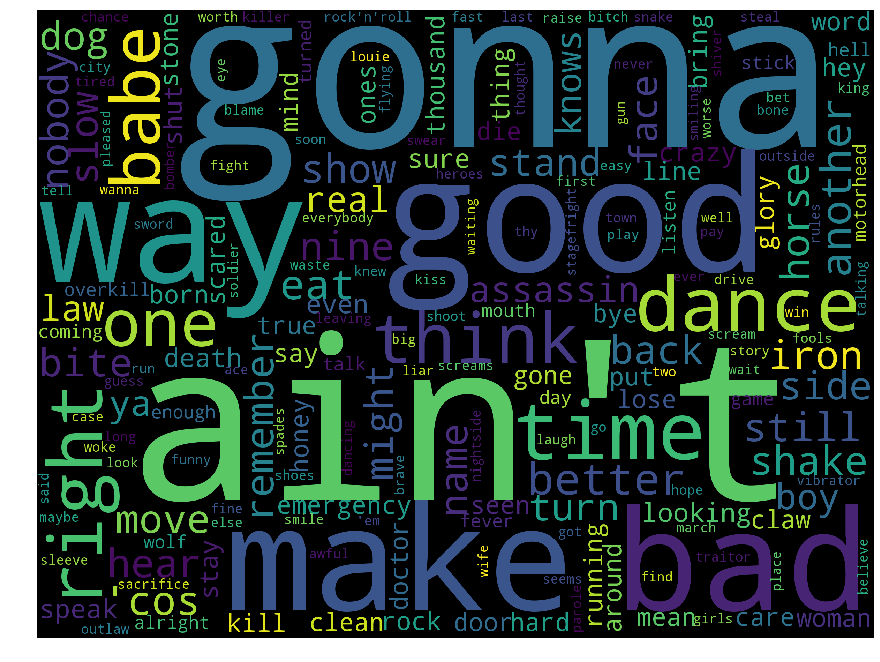

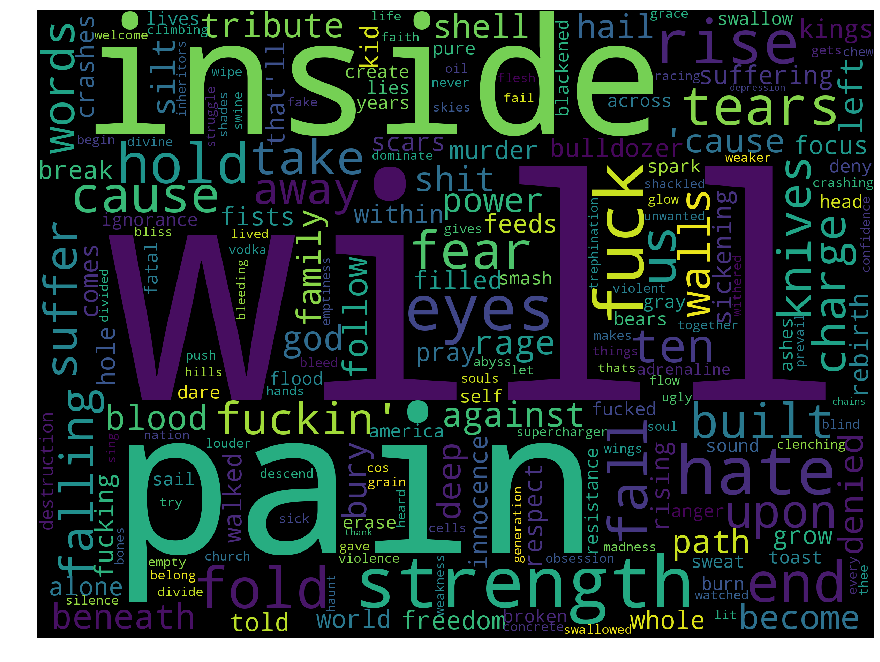

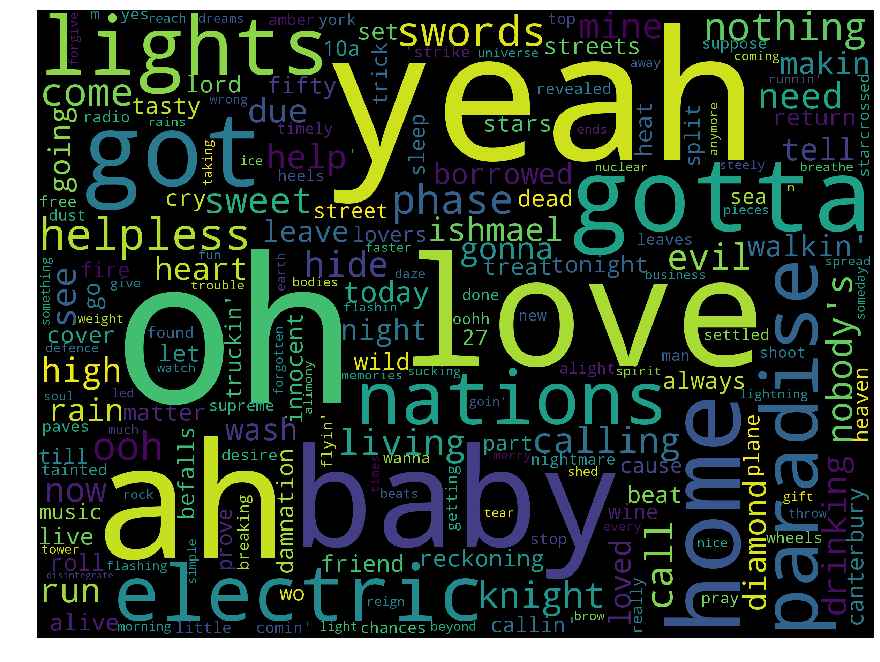

In [37]:
plot_word_cloud(sorted(motorhead_ll.items(), key=lambda x:-x[1])[:200], "resources/motorhead-ll-wordcloud.png")
plot_word_cloud(sorted(machinehead_ll.items(), key=lambda x:-x[1])[:200], "resources/machinehead-ll-wordcloud.png")
plot_word_cloud(sorted(diamondhead_ll.items(), key=lambda x:-x[1])[:200], "resources/diamondhead-ll-wordcloud.png")

# TF-IDF of all songs 

In [22]:
limited_lyrics = lyrics[lyrics.band_name.isin(bands)].copy()

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS

stop_words = ENGLISH_STOP_WORDS.union(tokenizer.CHARACTERS_TO_SPLIT)

vectorizer = TfidfVectorizer(
    stop_words=stop_words,
    lowercase=True,
    max_df=0.7,
    min_df=0.001,
    ngram_range=(1,3),
    tokenizer=tokenizer.tokenize_strip_non_words,
    norm=None
)

limited_lyrics["vectors_unnormalised"] = list(vectorizer.fit_transform(limited_lyrics.lyrics.values).toarray())

In [70]:
def normalise(vec):
    return vec / np.dot(vec,vec)

def combine_vectors(vectors):
    return normalise(np.sum(vectors, axis=0))

limited_lyrics["vectors"] = limited_lyrics.vectors_unnormalised.apply(normalise)

band_vectors = (
    limited_lyrics
    .groupby("band_name")
    .vectors
    .apply(combine_vectors)
)


In [71]:
from scipy.spatial.distance import cosine as cs

bands = band_lyrics.band_name.unique()
   
def important_words(vec, n):
    return sorted(zip(vectorizer.get_feature_names(), vec), key=lambda x:x[1], reverse=True)[:n]

def most_representative_songs(vec, n):
    df = limited_lyrics.copy()
    df["dist"] = df.vectors.apply(lambda x: cs(vec, x))
    df.drop_duplicates(["band_name", "song_name"], inplace=True)
    df.sort_values("dist", inplace=True, ascending=True)
    return df[:n]

def most_representative_bands(vec, n):
    df = band_vectors.reset_index().copy()
    df["dist"] = df.vectors.apply(lambda x: cs(vec, x))
    df.sort_values("dist", inplace=True, ascending=True)
    return df[:n]

In [72]:
most_representative_songs(band_vectors.ix["slayer"], 5)

,song_name,album_name,band_name,lyrics,vectors,vectors_unnormalised,dist
101564,Black Magic (Live),liveundeadhauntingthechapel,slayer,Cursed\nBlack magic night\nWe've been struck d...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.661188
101508,Black Magic,liveundead,slayer,Cursed\nBlack magic night\nWe've been struck d...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.665384
46042,Black Magic,inferiordevoties,hypocrisy,\nCursed\nBlack magic night\nWe've been struck...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.665384
101569,Show No Mercy (Live),liveundeadhauntingthechapel,slayer,Through the night we rise in pairs\nLords at n...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.675371
101514,Show No Mercy,liveundead,slayer,Through the night we rise in pairs\nLords at n...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.675371


In [101]:
metallica_v = band_vectors.ix["slayer"]
ironmaiden_v = band_vectors.ix["ironmaiden"]
notb_v = limited_lyrics[limited_lyrics.song_name == " The Number Of The Beast"].vectors.values[0]

In [103]:
most_representative_songs(metallica_v, 5)

,song_name,album_name,band_name,lyrics,vectors,vectors_unnormalised,dist
101564,Black Magic (Live),liveundeadhauntingthechapel,slayer,Cursed\nBlack magic night\nWe've been struck d...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.661188
101508,Black Magic,liveundead,slayer,Cursed\nBlack magic night\nWe've been struck d...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.665384
46042,Black Magic,inferiordevoties,hypocrisy,\nCursed\nBlack magic night\nWe've been struck...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.665384
101569,Show No Mercy (Live),liveundeadhauntingthechapel,slayer,Through the night we rise in pairs\nLords at n...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.675371
101514,Show No Mercy,liveundead,slayer,Through the night we rise in pairs\nLords at n...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.675371


In [102]:
most_representative_songs(notb_v - ironmaiden_v + metallica_v, 5)

,song_name,album_name,band_name,lyrics,vectors,vectors_unnormalised,dist
101564,Black Magic (Live),liveundeadhauntingthechapel,slayer,Cursed\nBlack magic night\nWe've been struck d...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.807857
46042,Black Magic,inferiordevoties,hypocrisy,\nCursed\nBlack magic night\nWe've been struck...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.812742
101508,Black Magic,liveundead,slayer,Cursed\nBlack magic night\nWe've been struck d...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.812742
101566,Captor Of Sin (Live),liveundeadhauntingthechapel,slayer,Harlots of Hell spread your wings\nAs I penetr...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.815822
101485,Captor Of Sin,hauntingthechapel,slayer,\nHarlots of Hell spread your wings\nAs I pene...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.815822


# Colouring words based on TF-IDF 

In [73]:
def colour_word_html(word, colour):
    if colour == "black":
        return word
    return '<span style="color:' + colour + '">' + word + '</span>'

def colour_word(word):
    norm = mpl.colors.Normalize(vmin=0, vmax=10)
    cmap = plt.cm.autumn_r
    m = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    
    score = score_word(word)
    return mpl.colors.rgb2hex(m.to_rgba(score)) if score > 0 else "black"

def score_word(word):
    return np.sum(np.sum(vectorizer.transform([word]).toarray()))

def colour_line(line):
    return " ".join([colour_word_html(w, colour_word(w))
                     for w in tokenizer.tokenize_words(line)])

In [78]:
ex = limited_lyrics[limited_lyrics.song_name == " Orgasmatron"].lyrics.values[0]

output = ""
for l in ex.split("\n"):
    output += (colour_line(l) + "<br>") #+ " - " + str(s) + "</br>")
    
from IPython.core.display import display, HTML
display(HTML(output))

In [79]:
print(output)

i am the one orgasmatron<br>the oustreched <span style="color:#ff4a00">grasping</span> <span style="color:#ffab00">hand</span><br>my <span style="color:#ff6e00">image</span> is of <span style="color:#ff7c00">agony</span><br>my <span style="color:#ff5600">servants</span> <span style="color:#ff7400">rape</span> the <span style="color:#ffa200">land</span><br>obsequious and <span style="color:#ff5200">arrogance</span><br>clandestine and <span style="color:#ffb800">pain</span><br>two thousend <span style="color:#ff9e00">years</span> of <span style="color:#ff8600">misery</span><br>of <span style="color:#ff7900">torture</span> in my name<br><span style="color:#ff6000">hypocrisy</span> made paramount<br><span style="color:#ff5200">paranoia</span> the <span style="color:#ff8600">law</span><br>my name is <span style="color:#ff8400">called</span> <span style="color:#ff7c00">religion</span><br><span style="color:#ff4b00">sadistic</span><br><span style="color:#ff8400">sacred</span><br><span style="

# Clustering

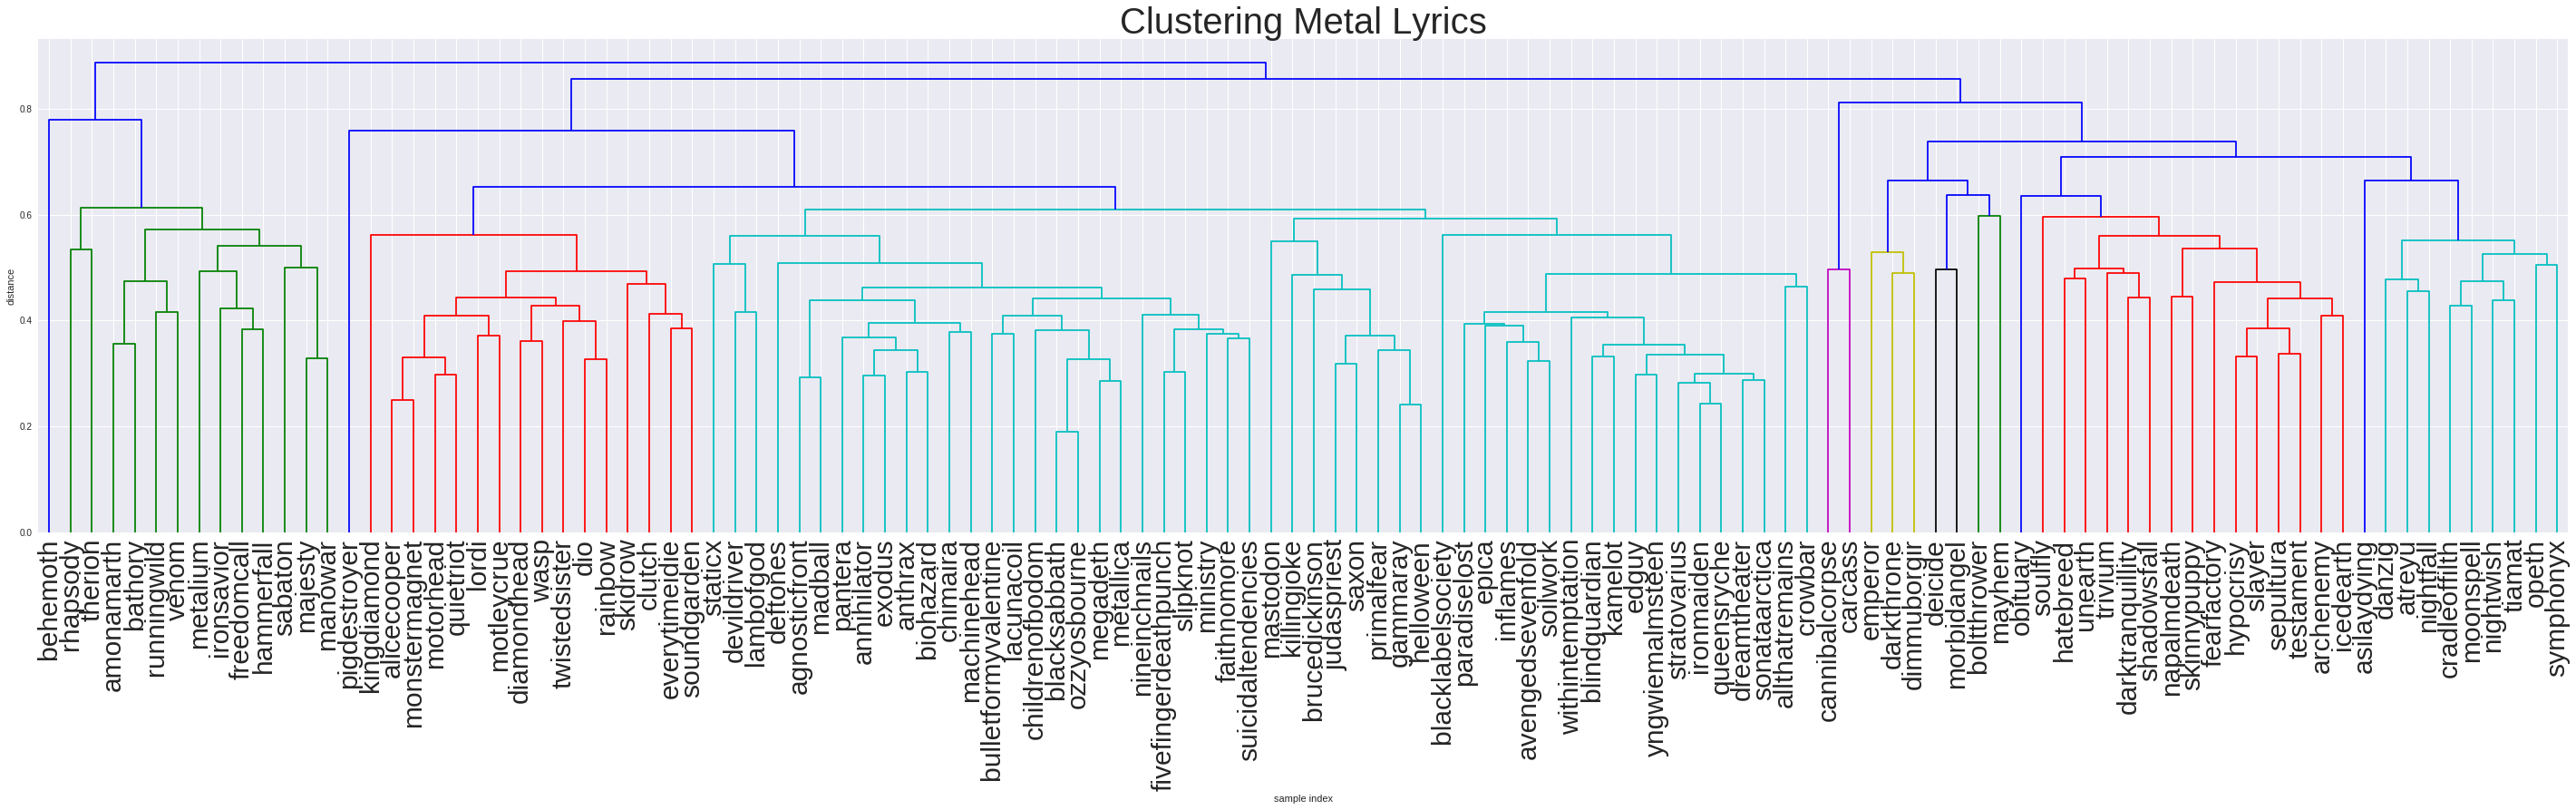

In [88]:
from scipy.cluster.hierarchy import dendrogram, linkage, to_tree, fcluster

Z = linkage(np.stack(list(band_vectors.values)), method='complete', metric="cosine")

n_clusters = fcluster(Z, 0.57, criterion='distance')

plt.figure(figsize=(50, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=30.,  # font size for the x axis labels
    labels=band_vectors.index.values
)
plt.title("Clustering Metal Lyrics", fontsize=40)
plt.xticks(rotation=90)

plt.savefig("resources/band-clustering.png", bbox_inches='tight')
